# Financial Synthetic Data Generation using Zephyr-7B LLM
* Notebook by Adam Lang
* Date: 12/6/2024

# What is Synthetic Data?
* In a nutshell, synthetic data is info that is artifically generated and not generated by real-world events or human annotators.
* It is usually created using algorithms.
* It can be used to validate mathematical models and train new machine learning models.
* Data generated by computer simulations is often seen as synthetic data.
* The mechanism for synthetic data generation is usually as follows:

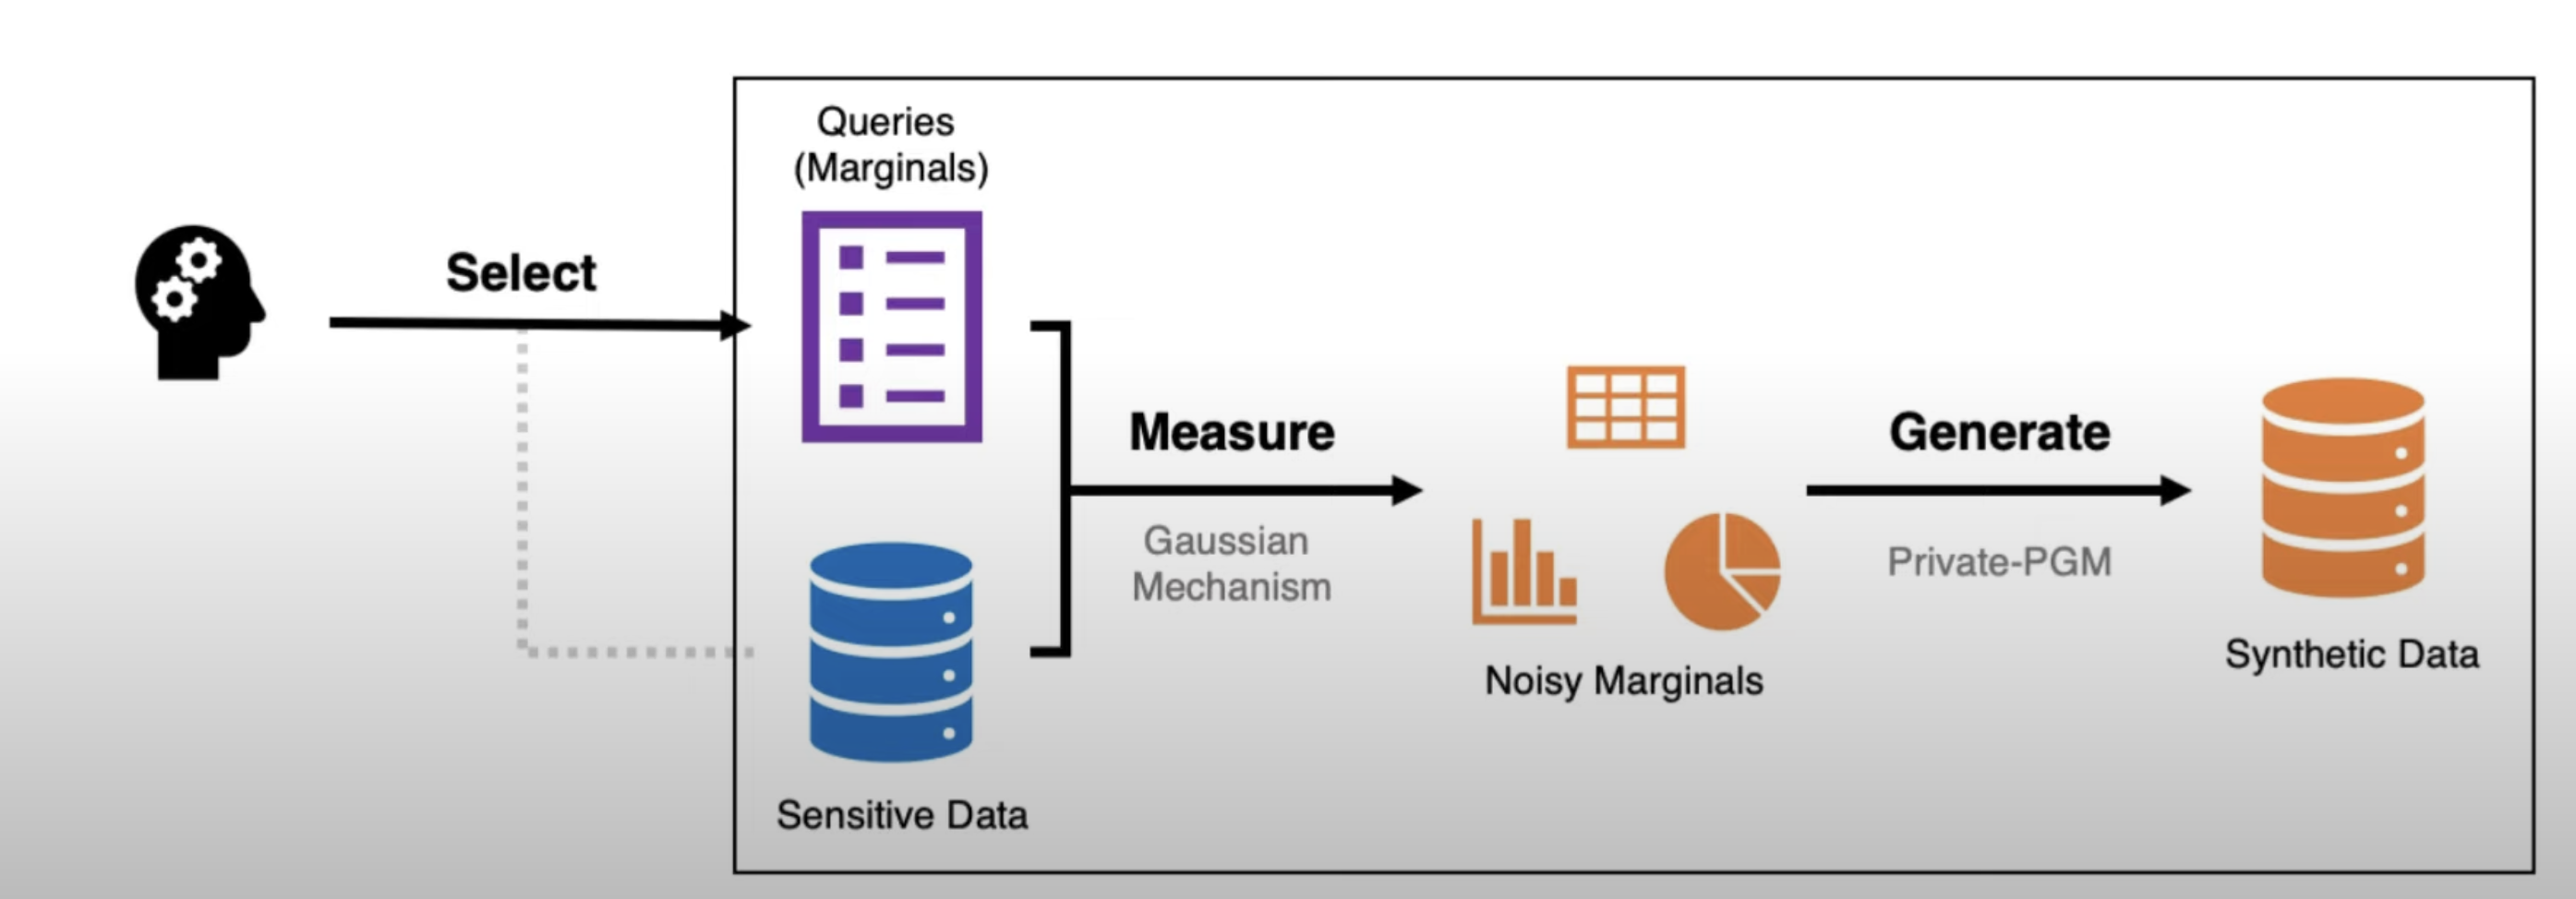

# Using Generative AI to generate Synthetic Data
* You can usually use RAG or Databases with your real world stored data.

# Implementation of Financial Data Synthetic Data Generation
* A big problem in the financial industry is being able to use real world data for building ML and AI models.
* We will demo how to create synthetic financial data using LangChain and an open source LLM.

## Project Workflow
1. Use open source data from DEMOG and BUREAU.
2. Load CSV data.
3. Load CSV data into vector DB using Hugging Face Embedding models.
4. Build QA-RAG Pipeline using LangChain and building a RAG architecture using an open source LLM Zephyr-7B.
5. Lastly, evaluate the responses generated by the synthetic data that was generated.

In [1]:
## install faker: https://pypi.org/project/Faker/
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.3 MB/s eta 0:00:00


In [2]:
## other installs
!pip install langchain langchain-community langchain-core transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.0 MB/s eta 0:00:00


In [3]:
## other installs
!pip install sentence-transformers #embeddings
!pip install chromadb #vector db
!pip install bitsandbytes accelerate ##huggingface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.3/628.3 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 3.2 MB/s eta 0:00:00


# Import Dependencies

In [4]:
from faker import Faker
import random
from datetime import date
from dateutil.relativedelta import relativedelta
import json
from langchain.vectorstores import Chroma # vector db
from transformers import RagTokenizer, RagRetriever, RagSequenceForGeneration
from transformers import pipeline

# Generate Synthetic Data

In [5]:
## init Faker library for generating synthetic data
fake = Faker()

## define a date range for queries
six_months = date.today() - relativedelta(months=+6)
three_months = date.today() - relativedelta(months=+3)

# Generate synthetic data function
def generate_synthetic_data(num_records):
    synthetic_data = []
    for _ in range(num_records):
      age = random.randint(20, 70)
      gender = random.choice(['Male', 'Female'])
      marital_status = random.choice(['Married', 'Single', 'Divorced', 'Widowed'])
      income_level = random.choice(['Low', 'Medium', 'High'])
      education = random.choice(['High School', 'Bachelor', 'Master', 'PhD'])
      occupation = fake.job()
      residential_status = random.choice(['Owns house', 'Rents', 'Living with parents'])
      dependents = random.randint(0, 5)
      debt_to_income = round(random.uniform(0.1, 0.5), 2)
      credit_bureau = random.randint(300, 850)
      credit_history = random

      # Generate inquiries for the last 3 and 6 months
      last_3months_inquiries = generate_inquiries(three_months)
      last_6months_inquiries = generate_inquiries(six_months)

        # Construct the record
      record = {
            'Customer ID': str(fake.uuid4()),
            'Age': age,
            'Gender': gender,
            'Marital Status': marital_status,
            'Income Level': income_level,
            'Education': education,
            'Occupation': occupation,
            'Residential Status': residential_status,
            'Dependents': dependents,
            'Debt-to-Income': debt_to_income,
            'Credit Bureau': credit_bureau,
            'last_3months_personal_loan_inq': any(i['product_name'] == 'Personal Loan' for i in last_3months_inquiries),
            'last_3months_credit_card_inq': any(i['product_name'] == 'Credit Card' for i in last_3months_inquiries),
            'last_3months_mortgage_inq': any(i['product_name'] == 'Mortgage' for i in last_3months_inquiries),
            'last_6months_personal_loan_inq': any(i['product_name'] == 'Personal Loan' for i in last_6months_inquiries),
            'last_6months_credit_card_inq': any(i['product_name'] == 'Credit Card' for i in last_6months_inquiries),
            'last_6months_mortgage_inq': any(i['product_name'] == 'Mortgage' for i in last_6months_inquiries)
        }
      synthetic_data.append(record)
    return synthetic_data

# Function to generate bureau product inquiries
def generate_inquiries(last_months):
    inquiries = []
    today = fake.date_this_month()
    for _ in range(random.randint(1, 5)):
        inquiry_date = fake.date_between(start_date=last_months, end_date=today)
        product_type = random.choice(['Personal Loan', 'Credit Card', 'Mortgage'])
        inquiries.append({'product_name': product_type, 'date': inquiry_date})
    return inquiries if inquiries else []

# Generate synthetic data
synthetic_data = generate_synthetic_data(50)
synthetic_data[0]

{'Customer ID': 'ec129f2d-be13-4d0f-83ae-d47c9bfed8d7',
 'Age': 33,
 'Gender': 'Female',
 'Marital Status': 'Widowed',
 'Income Level': 'High',
 'Education': 'High School',
 'Occupation': 'Health visitor',
 'Residential Status': 'Owns house',
 'Dependents': 2,
 'Debt-to-Income': 0.44,
 'Credit Bureau': 496,
 'last_3months_personal_loan_inq': True,
 'last_3months_credit_card_inq': True,
 'last_3months_mortgage_inq': False,
 'last_6months_personal_loan_inq': True,
 'last_6months_credit_card_inq': True,
 'last_6months_mortgage_inq': True}

In [6]:
## import the synthetic data
import pandas as pd
data_df = pd.DataFrame(synthetic_data)
## create content colujmn
data_df['content'] = [f"Here is the Customer Data: {data}." for data in synthetic_data]
data_df.head()


,Customer ID,Age,Gender,Marital Status,Income Level,Education,Occupation,Residential Status,Dependents,Debt-to-Income,Credit Bureau,last_3months_personal_loan_inq,last_3months_credit_card_inq,last_3months_mortgage_inq,last_6months_personal_loan_inq,last_6months_credit_card_inq,last_6months_mortgage_inq,content
0,ec129f2d-be13-4d0f-83ae-d47c9bfed8d7,33,Female,Widowed,High,High School,Health visitor,Owns house,2,0.44,496,True,True,False,True,True,True,Here is the Customer Data: {'Customer ID': 'ec...
1,18d426dc-c6da-457a-9696-729f2bd735f9,29,Female,Widowed,High,Master,Osteopath,Owns house,2,0.23,816,False,True,True,False,False,True,Here is the Customer Data: {'Customer ID': '18...
2,86b0b141-b726-4ec8-b58f-3f1b1f2bc609,28,Male,Married,Medium,Master,Copy,Rents,1,0.42,785,True,True,False,True,False,False,Here is the Customer Data: {'Customer ID': '86...
3,b0998441-3ecd-42ea-83bf-3f21068c3f30,30,Male,Married,Low,Master,Paramedic,Living with parents,5,0.30,451,False,True,False,True,True,True,Here is the Customer Data: {'Customer ID': 'b0...
4,55d9b0d3-6e16-4d17-8ff1-b54e63dae7aa,59,Male,Married,Low,Master,Therapeutic radiographer,Rents,5,0.16,348,False,True,True,False,False,True,Here is the Customer Data: {'Customer ID': '55...


# Convert Synthetic Data into Document Format to Store into Vector DB

In [7]:
from langchain.docstore.document import Document

# prepare docs for LangChain
documents = []
for _, row in data_df.iterrows():
  documents.append(Document(page_content=row["content"], metadata={"class": row["Age"]}))


# Load `HuggingFaceEmbeddings`

In [8]:
from langchain_community.embeddings import HuggingFaceEmbeddings

## init embeddings function
hg_embeddings = HuggingFaceEmbeddings()

<ipython-input-8-f8182f3265f9>:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  hg_embeddings = HuggingFaceEmbeddings()
<ipython-input-8-f8182f3265f9>:4: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  hg_embeddings = HuggingFaceEmbeddings()


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Store Data in VectorDB (ChromaDB)

In [9]:
from langchain.vectorstores import Chroma

## persist dir
persist_directory = '/content/'

## init vector db
langchain_chroma = Chroma.from_documents(
    documents=documents,
    collection_name="recomendation_engine",
    embedding=hg_embeddings,
    persist_directory=persist_directory
)

# Load Open Source LLM: Zephyr 7B
* Model card: https://huggingface.co/HuggingFaceH4/zephyr-7b-beta
* Zephyr is a series of language models that are trained to act as helpful assistants.
  * Zephyr-7B-β is the second model in the series, and is a fine-tuned version of mistralai/Mistral-7B-v0.1 that was trained on on a mix of:
    * publicly available synthetic datasets using Direct Preference Optimization (DPO)
  * They found that removing the in-built alignment of these datasets boosted performance on MT Bench and made the model more helpful.
  * **However, this means that model is likely to generate problematic text when prompted to do so.**

In [10]:
from torch import cuda, bfloat16
import torch
import transformers
from transformers import AutoTokenizer
from time import time
from langchain.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
from langchain.vectorstores import Chroma
import os

## load model from HF
model_id = "HuggingFaceH4/zephyr-7b-beta"


## setup device agnostic code
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

## we need to set quantization config to load LLM with less GPU memory
## this requires `bitsandbytes` library
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16,
)

## view device
print(device)

## set cuda launch blocking
## CUDA_LAUNCH_BLOCKING=1 is a debug env variable used to block kernel launches and
## to report the proper stacktrace once an assert is triggered.
## You should not use it in production, but only during debugging.
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## model config
model_config = transformers.AutoConfig.from_pretrained(
    model_id,
    trust_remote_code=True,
    max_new_tokens=1024,
)

## setup LLM model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto',
)

## model tokenizer
model_tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    use_fast=True,
)

cuda:0


config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

# Building Query Pipeline

In [12]:
## init the query pipeine with increased max_length
query_pipe = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=model_tokenizer,
    torch_dtype=torch.float16,
    max_length=6000,
    max_new_tokens=500,
    device_map="cpu",
)

## init llm pipeline
llm = HuggingFacePipeline(pipeline=query_pipe)

In [13]:
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain_community.llms import HuggingFaceHub
from IPython.display import display, Markdown
import os
import warnings
warnings.filterwarnings("ignore") #ignore warnings

#if you want to load your own HF key here
#os.environ["HUGGINGFACEHUB_API_TOKEN"] = <YOUR KEY HERE>

# define prompt template
template = """
Based on the following customer data, that I Provide, Generate Synthetic Data 5 Rows based on the Pattern you found in the data."
Customer Information: {question}
Context: {context}
Answer:
"""
PROMPT = PromptTemplate(input_variables=["context","query"], template=template)

## retrieve from chroma vector database
retriever = langchain_chroma.as_retriever(search_kwargs={"k": 1})

## setup QA chain
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=retriever,
    chain_type_kwargs={"prompt": PROMPT},
)

In [14]:
# Convert data to prompt format for training RAG model
prompt_data = [
    {
        'prompt': f"Generate synthetic data for a customer with the following attributes: {json.dumps(record)}",
        'metadata': record
    }
    for record in synthetic_data
]
data = json.dumps(prompt_data, indent=4)

# example prompt for synthetic data generation
prompt_text = "Generate synthetic data 2 rows by analyzing this data and identify the pattern to generate the desired synthetic data, Data - {data}".format(data=data)

try:
  result=qa_chain({"query": data})
  display(result)
except RuntimeError as e:
  print(f"RuntimeError encountered: {e}")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=500) and `max_length`(=6000) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


{'query': '[\n    {\n        "prompt": "Generate synthetic data for a customer with the following attributes: {\\"Customer ID\\": \\"ec129f2d-be13-4d0f-83ae-d47c9bfed8d7\\", \\"Age\\": 33, \\"Gender\\": \\"Female\\", \\"Marital Status\\": \\"Widowed\\", \\"Income Level\\": \\"High\\", \\"Education\\": \\"High School\\", \\"Occupation\\": \\"Health visitor\\", \\"Residential Status\\": \\"Owns house\\", \\"Dependents\\": 2, \\"Debt-to-Income\\": 0.44, \\"Credit Bureau\\": 496, \\"last_3months_personal_loan_inq\\": true, \\"last_3months_credit_card_inq\\": true, \\"last_3months_mortgage_inq\\": false, \\"last_6months_personal_loan_inq\\": true, \\"last_6months_credit_card_inq\\": true, \\"last_6months_mortgage_inq\\": true}",\n        "metadata": {\n            "Customer ID": "ec129f2d-be13-4d0f-83ae-d47c9bfed8d7",\n            "Age": 33,\n            "Gender": "Female",\n            "Marital Status": "Widowed",\n            "Income Level": "High",\n            "Education": "High School"

In [25]:
result.keys()

dict_keys(['query', 'result'])

In [29]:
## display markdown of 1 key
display(Markdown(result['result']))


Based on the following customer data, that I Provide, Generate Synthetic Data 5 Rows based on the Pattern you found in the data."
Customer Information: [
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"ec129f2d-be13-4d0f-83ae-d47c9bfed8d7\", \"Age\": 33, \"Gender\": \"Female\", \"Marital Status\": \"Widowed\", \"Income Level\": \"High\", \"Education\": \"High School\", \"Occupation\": \"Health visitor\", \"Residential Status\": \"Owns house\", \"Dependents\": 2, \"Debt-to-Income\": 0.44, \"Credit Bureau\": 496, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": false, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "ec129f2d-be13-4d0f-83ae-d47c9bfed8d7",
            "Age": 33,
            "Gender": "Female",
            "Marital Status": "Widowed",
            "Income Level": "High",
            "Education": "High School",
            "Occupation": "Health visitor",
            "Residential Status": "Owns house",
            "Dependents": 2,
            "Debt-to-Income": 0.44,
            "Credit Bureau": 496,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": false,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"18d426dc-c6da-457a-9696-729f2bd735f9\", \"Age\": 29, \"Gender\": \"Female\", \"Marital Status\": \"Widowed\", \"Income Level\": \"High\", \"Education\": \"Master\", \"Occupation\": \"Osteopath\", \"Residential Status\": \"Owns house\", \"Dependents\": 2, \"Debt-to-Income\": 0.23, \"Credit Bureau\": 816, \"last_3months_personal_loan_inq\": false, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": false, \"last_6months_credit_card_inq\": false, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "18d426dc-c6da-457a-9696-729f2bd735f9",
            "Age": 29,
            "Gender": "Female",
            "Marital Status": "Widowed",
            "Income Level": "High",
            "Education": "Master",
            "Occupation": "Osteopath",
            "Residential Status": "Owns house",
            "Dependents": 2,
            "Debt-to-Income": 0.23,
            "Credit Bureau": 816,
            "last_3months_personal_loan_inq": false,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": false,
            "last_6months_credit_card_inq": false,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"86b0b141-b726-4ec8-b58f-3f1b1f2bc609\", \"Age\": 28, \"Gender\": \"Male\", \"Marital Status\": \"Married\", \"Income Level\": \"Medium\", \"Education\": \"Master\", \"Occupation\": \"Copy\", \"Residential Status\": \"Rents\", \"Dependents\": 1, \"Debt-to-Income\": 0.42, \"Credit Bureau\": 785, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": false, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": false, \"last_6months_mortgage_inq\": false}",
        "metadata": {
            "Customer ID": "86b0b141-b726-4ec8-b58f-3f1b1f2bc609",
            "Age": 28,
            "Gender": "Male",
            "Marital Status": "Married",
            "Income Level": "Medium",
            "Education": "Master",
            "Occupation": "Copy",
            "Residential Status": "Rents",
            "Dependents": 1,
            "Debt-to-Income": 0.42,
            "Credit Bureau": 785,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": false,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": false,
            "last_6months_mortgage_inq": false
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"b0998441-3ecd-42ea-83bf-3f21068c3f30\", \"Age\": 30, \"Gender\": \"Male\", \"Marital Status\": \"Married\", \"Income Level\": \"Low\", \"Education\": \"Master\", \"Occupation\": \"Paramedic\", \"Residential Status\": \"Living with parents\", \"Dependents\": 5, \"Debt-to-Income\": 0.3, \"Credit Bureau\": 451, \"last_3months_personal_loan_inq\": false, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": false, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "b0998441-3ecd-42ea-83bf-3f21068c3f30",
            "Age": 30,
            "Gender": "Male",
            "Marital Status": "Married",
            "Income Level": "Low",
            "Education": "Master",
            "Occupation": "Paramedic",
            "Residential Status": "Living with parents",
            "Dependents": 5,
            "Debt-to-Income": 0.3,
            "Credit Bureau": 451,
            "last_3months_personal_loan_inq": false,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": false,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"55d9b0d3-6e16-4d17-8ff1-b54e63dae7aa\", \"Age\": 59, \"Gender\": \"Male\", \"Marital Status\": \"Married\", \"Income Level\": \"Low\", \"Education\": \"Master\", \"Occupation\": \"Therapeutic radiographer\", \"Residential Status\": \"Rents\", \"Dependents\": 5, \"Debt-to-Income\": 0.16, \"Credit Bureau\": 348, \"last_3months_personal_loan_inq\": false, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": false, \"last_6months_credit_card_inq\": false, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "55d9b0d3-6e16-4d17-8ff1-b54e63dae7aa",
            "Age": 59,
            "Gender": "Male",
            "Marital Status": "Married",
            "Income Level": "Low",
            "Education": "Master",
            "Occupation": "Therapeutic radiographer",
            "Residential Status": "Rents",
            "Dependents": 5,
            "Debt-to-Income": 0.16,
            "Credit Bureau": 348,
            "last_3months_personal_loan_inq": false,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": false,
            "last_6months_credit_card_inq": false,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"8ef7f3ed-fa0e-49b9-86fe-2f316d6b2839\", \"Age\": 22, \"Gender\": \"Male\", \"Marital Status\": \"Married\", \"Income Level\": \"High\", \"Education\": \"PhD\", \"Occupation\": \"Printmaker\", \"Residential Status\": \"Rents\", \"Dependents\": 2, \"Debt-to-Income\": 0.11, \"Credit Bureau\": 538, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": false, \"last_3months_mortgage_inq\": false, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": false, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "8ef7f3ed-fa0e-49b9-86fe-2f316d6b2839",
            "Age": 22,
            "Gender": "Male",
            "Marital Status": "Married",
            "Income Level": "High",
            "Education": "PhD",
            "Occupation": "Printmaker",
            "Residential Status": "Rents",
            "Dependents": 2,
            "Debt-to-Income": 0.11,
            "Credit Bureau": 538,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": false,
            "last_3months_mortgage_inq": false,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": false,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"8dafb19c-99ff-49ea-848a-6c6b2b47d407\", \"Age\": 26, \"Gender\": \"Male\", \"Marital Status\": \"Married\", \"Income Level\": \"High\", \"Education\": \"PhD\", \"Occupation\": \"Accommodation manager\", \"Residential Status\": \"Owns house\", \"Dependents\": 2, \"Debt-to-Income\": 0.13, \"Credit Bureau\": 419, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": false, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": false, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": false}",
        "metadata": {
            "Customer ID": "8dafb19c-99ff-49ea-848a-6c6b2b47d407",
            "Age": 26,
            "Gender": "Male",
            "Marital Status": "Married",
            "Income Level": "High",
            "Education": "PhD",
            "Occupation": "Accommodation manager",
            "Residential Status": "Owns house",
            "Dependents": 2,
            "Debt-to-Income": 0.13,
            "Credit Bureau": 419,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": false,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": false,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": false
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"7e71d16e-af60-4108-a025-0c7aa0670f0b\", \"Age\": 29, \"Gender\": \"Male\", \"Marital Status\": \"Single\", \"Income Level\": \"Low\", \"Education\": \"Master\", \"Occupation\": \"Civil engineer, consulting\", \"Residential Status\": \"Rents\", \"Dependents\": 1, \"Debt-to-Income\": 0.13, \"Credit Bureau\": 782, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": false, \"last_3months_mortgage_inq\": false, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "7e71d16e-af60-4108-a025-0c7aa0670f0b",
            "Age": 29,
            "Gender": "Male",
            "Marital Status": "Single",
            "Income Level": "Low",
            "Education": "Master",
            "Occupation": "Civil engineer, consulting",
            "Residential Status": "Rents",
            "Dependents": 1,
            "Debt-to-Income": 0.13,
            "Credit Bureau": 782,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": false,
            "last_3months_mortgage_inq": false,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"68698190-9e05-4210-90cb-e5a6080ea18b\", \"Age\": 70, \"Gender\": \"Female\", \"Marital Status\": \"Widowed\", \"Income Level\": \"High\", \"Education\": \"Master\", \"Occupation\": \"Customer service manager\", \"Residential Status\": \"Rents\", \"Dependents\": 5, \"Debt-to-Income\": 0.46, \"Credit Bureau\": 319, \"last_3months_personal_loan_inq\": false, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": false, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": false}",
        "metadata": {
            "Customer ID": "68698190-9e05-4210-90cb-e5a6080ea18b",
            "Age": 70,
            "Gender": "Female",
            "Marital Status": "Widowed",
            "Income Level": "High",
            "Education": "Master",
            "Occupation": "Customer service manager",
            "Residential Status": "Rents",
            "Dependents": 5,
            "Debt-to-Income": 0.46,
            "Credit Bureau": 319,
            "last_3months_personal_loan_inq": false,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": false,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": false
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"7a4c345e-490f-49ba-93b1-006468e34ad4\", \"Age\": 59, \"Gender\": \"Male\", \"Marital Status\": \"Single\", \"Income Level\": \"Medium\", \"Education\": \"Master\", \"Occupation\": \"Administrator, charities/voluntary organisations\", \"Residential Status\": \"Owns house\", \"Dependents\": 1, \"Debt-to-Income\": 0.12, \"Credit Bureau\": 560, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": false, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "7a4c345e-490f-49ba-93b1-006468e34ad4",
            "Age": 59,
            "Gender": "Male",
            "Marital Status": "Single",
            "Income Level": "Medium",
            "Education": "Master",
            "Occupation": "Administrator, charities/voluntary organisations",
            "Residential Status": "Owns house",
            "Dependents": 1,
            "Debt-to-Income": 0.12,
            "Credit Bureau": 560,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": false,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"8d62345b-d6ca-4736-b607-cd8dcdfaf5a2\", \"Age\": 63, \"Gender\": \"Male\", \"Marital Status\": \"Divorced\", \"Income Level\": \"Medium\", \"Education\": \"PhD\", \"Occupation\": \"Retail manager\", \"Residential Status\": \"Rents\", \"Dependents\": 5, \"Debt-to-Income\": 0.36, \"Credit Bureau\": 306, \"last_3months_personal_loan_inq\": false, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": false, \"last_6months_personal_loan_inq\": false, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "8d62345b-d6ca-4736-b607-cd8dcdfaf5a2",
            "Age": 63,
            "Gender": "Male",
            "Marital Status": "Divorced",
            "Income Level": "Medium",
            "Education": "PhD",
            "Occupation": "Retail manager",
            "Residential Status": "Rents",
            "Dependents": 5,
            "Debt-to-Income": 0.36,
            "Credit Bureau": 306,
            "last_3months_personal_loan_inq": false,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": false,
            "last_6months_personal_loan_inq": false,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"da78b3cc-271a-420c-be05-2aa854f5af16\", \"Age\": 45, \"Gender\": \"Male\", \"Marital Status\": \"Divorced\", \"Income Level\": \"High\", \"Education\": \"High School\", \"Occupation\": \"Librarian, academic\", \"Residential Status\": \"Rents\", \"Dependents\": 4, \"Debt-to-Income\": 0.34, \"Credit Bureau\": 326, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": false, \"last_6months_personal_loan_inq\": false, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "da78b3cc-271a-420c-be05-2aa854f5af16",
            "Age": 45,
            "Gender": "Male",
            "Marital Status": "Divorced",
            "Income Level": "High",
            "Education": "High School",
            "Occupation": "Librarian, academic",
            "Residential Status": "Rents",
            "Dependents": 4,
            "Debt-to-Income": 0.34,
            "Credit Bureau": 326,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": false,
            "last_6months_personal_loan_inq": false,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"cedf49c8-e684-4bd3-8b80-b06a1d9e345d\", \"Age\": 42, \"Gender\": \"Female\", \"Marital Status\": \"Single\", \"Income Level\": \"Low\", \"Education\": \"PhD\", \"Occupation\": \"Psychologist, prison and probation services\", \"Residential Status\": \"Owns house\", \"Dependents\": 2, \"Debt-to-Income\": 0.27, \"Credit Bureau\": 571, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": false, \"last_3months_mortgage_inq\": false, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": false, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "cedf49c8-e684-4bd3-8b80-b06a1d9e345d",
            "Age": 42,
            "Gender": "Female",
            "Marital Status": "Single",
            "Income Level": "Low",
            "Education": "PhD",
            "Occupation": "Psychologist, prison and probation services",
            "Residential Status": "Owns house",
            "Dependents": 2,
            "Debt-to-Income": 0.27,
            "Credit Bureau": 571,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": false,
            "last_3months_mortgage_inq": false,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": false,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"f763b012-7461-420f-a10c-9f02f0c7b814\", \"Age\": 20, \"Gender\": \"Male\", \"Marital Status\": \"Single\", \"Income Level\": \"Low\", \"Education\": \"Bachelor\", \"Occupation\": \"Animal nutritionist\", \"Residential Status\": \"Rents\", \"Dependents\": 2, \"Debt-to-Income\": 0.31, \"Credit Bureau\": 443, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": false, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": false, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "f763b012-7461-420f-a10c-9f02f0c7b814",
            "Age": 20,
            "Gender": "Male",
            "Marital Status": "Single",
            "Income Level": "Low",
            "Education": "Bachelor",
            "Occupation": "Animal nutritionist",
            "Residential Status": "Rents",
            "Dependents": 2,
            "Debt-to-Income": 0.31,
            "Credit Bureau": 443,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": false,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": false,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"e35f3f25-8edd-4c68-a367-63fbd2c1575f\", \"Age\": 58, \"Gender\": \"Female\", \"Marital Status\": \"Single\", \"Income Level\": \"Medium\", \"Education\": \"High School\", \"Occupation\": \"Clinical scientist, histocompatibility and immunogenetics\", \"Residential Status\": \"Living with parents\", \"Dependents\": 1, \"Debt-to-Income\": 0.32, \"Credit Bureau\": 566, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": false, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": false}",
        "metadata": {
            "Customer ID": "e35f3f25-8edd-4c68-a367-63fbd2c1575f",
            "Age": 58,
            "Gender": "Female",
            "Marital Status": "Single",
            "Income Level": "Medium",
            "Education": "High School",
            "Occupation": "Clinical scientist, histocompatibility and immunogenetics",
            "Residential Status": "Living with parents",
            "Dependents": 1,
            "Debt-to-Income": 0.32,
            "Credit Bureau": 566,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": false,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": false
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"ca7ae8e8-f10a-4160-b200-e180d7ed585e\", \"Age\": 36, \"Gender\": \"Male\", \"Marital Status\": \"Single\", \"Income Level\": \"High\", \"Education\": \"PhD\", \"Occupation\": \"Agricultural consultant\", \"Residential Status\": \"Living with parents\", \"Dependents\": 1, \"Debt-to-Income\": 0.37, \"Credit Bureau\": 376, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": false, \"last_6months_credit_card_inq\": false, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "ca7ae8e8-f10a-4160-b200-e180d7ed585e",
            "Age": 36,
            "Gender": "Male",
            "Marital Status": "Single",
            "Income Level": "High",
            "Education": "PhD",
            "Occupation": "Agricultural consultant",
            "Residential Status": "Living with parents",
            "Dependents": 1,
            "Debt-to-Income": 0.37,
            "Credit Bureau": 376,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": false,
            "last_6months_credit_card_inq": false,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"74ec5ac5-eb9f-4192-8756-1ffeac06431b\", \"Age\": 39, \"Gender\": \"Female\", \"Marital Status\": \"Divorced\", \"Income Level\": \"Medium\", \"Education\": \"Master\", \"Occupation\": \"Purchasing manager\", \"Residential Status\": \"Owns house\", \"Dependents\": 5, \"Debt-to-Income\": 0.16, \"Credit Bureau\": 661, \"last_3months_personal_loan_inq\": false, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": false, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": false, \"last_6months_mortgage_inq\": false}",
        "metadata": {
            "Customer ID": "74ec5ac5-eb9f-4192-8756-1ffeac06431b",
            "Age": 39,
            "Gender": "Female",
            "Marital Status": "Divorced",
            "Income Level": "Medium",
            "Education": "Master",
            "Occupation": "Purchasing manager",
            "Residential Status": "Owns house",
            "Dependents": 5,
            "Debt-to-Income": 0.16,
            "Credit Bureau": 661,
            "last_3months_personal_loan_inq": false,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": false,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": false,
            "last_6months_mortgage_inq": false
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"f1dce146-c098-4836-ba16-f7a35c3962d0\", \"Age\": 23, \"Gender\": \"Female\", \"Marital Status\": \"Married\", \"Income Level\": \"Low\", \"Education\": \"Bachelor\", \"Occupation\": \"Research officer, political party\", \"Residential Status\": \"Owns house\", \"Dependents\": 3, \"Debt-to-Income\": 0.3, \"Credit Bureau\": 425, \"last_3months_personal_loan_inq\": false, \"last_3months_credit_card_inq\": false, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": false}",
        "metadata": {
            "Customer ID": "f1dce146-c098-4836-ba16-f7a35c3962d0",
            "Age": 23,
            "Gender": "Female",
            "Marital Status": "Married",
            "Income Level": "Low",
            "Education": "Bachelor",
            "Occupation": "Research officer, political party",
            "Residential Status": "Owns house",
            "Dependents": 3,
            "Debt-to-Income": 0.3,
            "Credit Bureau": 425,
            "last_3months_personal_loan_inq": false,
            "last_3months_credit_card_inq": false,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": false
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"2de9583f-ae7b-4d54-abd8-e6a395712e04\", \"Age\": 54, \"Gender\": \"Male\", \"Marital Status\": \"Married\", \"Income Level\": \"Medium\", \"Education\": \"PhD\", \"Occupation\": \"Office manager\", \"Residential Status\": \"Owns house\", \"Dependents\": 3, \"Debt-to-Income\": 0.34, \"Credit Bureau\": 694, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": false, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": false, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": false}",
        "metadata": {
            "Customer ID": "2de9583f-ae7b-4d54-abd8-e6a395712e04",
            "Age": 54,
            "Gender": "Male",
            "Marital Status": "Married",
            "Income Level": "Medium",
            "Education": "PhD",
            "Occupation": "Office manager",
            "Residential Status": "Owns house",
            "Dependents": 3,
            "Debt-to-Income": 0.34,
            "Credit Bureau": 694,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": false,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": false,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": false
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"00451794-c066-4a2b-8bb0-099005ad193a\", \"Age\": 43, \"Gender\": \"Female\", \"Marital Status\": \"Single\", \"Income Level\": \"Medium\", \"Education\": \"Master\", \"Occupation\": \"Haematologist\", \"Residential Status\": \"Living with parents\", \"Dependents\": 1, \"Debt-to-Income\": 0.33, \"Credit Bureau\": 847, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": false, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": false, \"last_6months_credit_card_inq\": false, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "00451794-c066-4a2b-8bb0-099005ad193a",
            "Age": 43,
            "Gender": "Female",
            "Marital Status": "Single",
            "Income Level": "Medium",
            "Education": "Master",
            "Occupation": "Haematologist",
            "Residential Status": "Living with parents",
            "Dependents": 1,
            "Debt-to-Income": 0.33,
            "Credit Bureau": 847,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": false,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": false,
            "last_6months_credit_card_inq": false,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"1bdfe311-6317-4cf6-89e1-853739c448d2\", \"Age\": 42, \"Gender\": \"Female\", \"Marital Status\": \"Widowed\", \"Income Level\": \"Medium\", \"Education\": \"Master\", \"Occupation\": \"Surveyor, building control\", \"Residential Status\": \"Owns house\", \"Dependents\": 4, \"Debt-to-Income\": 0.48, \"Credit Bureau\": 450, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": false, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": false}",
        "metadata": {
            "Customer ID": "1bdfe311-6317-4cf6-89e1-853739c448d2",
            "Age": 42,
            "Gender": "Female",
            "Marital Status": "Widowed",
            "Income Level": "Medium",
            "Education": "Master",
            "Occupation": "Surveyor, building control",
            "Residential Status": "Owns house",
            "Dependents": 4,
            "Debt-to-Income": 0.48,
            "Credit Bureau": 450,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": false,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": false
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"e498f4b3-4141-46a2-9c3d-7f76dbdcc934\", \"Age\": 22, \"Gender\": \"Female\", \"Marital Status\": \"Divorced\", \"Income Level\": \"High\", \"Education\": \"Bachelor\", \"Occupation\": \"Clothing/textile technologist\", \"Residential Status\": \"Owns house\", \"Dependents\": 3, \"Debt-to-Income\": 0.41, \"Credit Bureau\": 323, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "e498f4b3-4141-46a2-9c3d-7f76dbdcc934",
            "Age": 22,
            "Gender": "Female",
            "Marital Status": "Divorced",
            "Income Level": "High",
            "Education": "Bachelor",
            "Occupation": "Clothing/textile technologist",
            "Residential Status": "Owns house",
            "Dependents": 3,
            "Debt-to-Income": 0.41,
            "Credit Bureau": 323,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"0454e1f5-bd03-4bb1-89b1-35f40799d314\", \"Age\": 69, \"Gender\": \"Male\", \"Marital Status\": \"Widowed\", \"Income Level\": \"High\", \"Education\": \"Master\", \"Occupation\": \"Horticultural therapist\", \"Residential Status\": \"Living with parents\", \"Dependents\": 0, \"Debt-to-Income\": 0.29, \"Credit Bureau\": 685, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": false, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": false, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": false}",
        "metadata": {
            "Customer ID": "0454e1f5-bd03-4bb1-89b1-35f40799d314",
            "Age": 69,
            "Gender": "Male",
            "Marital Status": "Widowed",
            "Income Level": "High",
            "Education": "Master",
            "Occupation": "Horticultural therapist",
            "Residential Status": "Living with parents",
            "Dependents": 0,
            "Debt-to-Income": 0.29,
            "Credit Bureau": 685,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": false,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": false,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": false
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"33eded88-ab92-40b5-8ce4-3ae8067008c3\", \"Age\": 57, \"Gender\": \"Female\", \"Marital Status\": \"Widowed\", \"Income Level\": \"Low\", \"Education\": \"High School\", \"Occupation\": \"Diplomatic Services operational officer\", \"Residential Status\": \"Rents\", \"Dependents\": 4, \"Debt-to-Income\": 0.15, \"Credit Bureau\": 689, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": false, \"last_6months_mortgage_inq\": false}",
        "metadata": {
            "Customer ID": "33eded88-ab92-40b5-8ce4-3ae8067008c3",
            "Age": 57,
            "Gender": "Female",
            "Marital Status": "Widowed",
            "Income Level": "Low",
            "Education": "High School",
            "Occupation": "Diplomatic Services operational officer",
            "Residential Status": "Rents",
            "Dependents": 4,
            "Debt-to-Income": 0.15,
            "Credit Bureau": 689,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": false,
            "last_6months_mortgage_inq": false
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"f285a35e-9c11-458a-8ce3-cba7d58b9473\", \"Age\": 69, \"Gender\": \"Male\", \"Marital Status\": \"Divorced\", \"Income Level\": \"Medium\", \"Education\": \"Master\", \"Occupation\": \"Bonds trader\", \"Residential Status\": \"Rents\", \"Dependents\": 5, \"Debt-to-Income\": 0.46, \"Credit Bureau\": 380, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": false, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "f285a35e-9c11-458a-8ce3-cba7d58b9473",
            "Age": 69,
            "Gender": "Male",
            "Marital Status": "Divorced",
            "Income Level": "Medium",
            "Education": "Master",
            "Occupation": "Bonds trader",
            "Residential Status": "Rents",
            "Dependents": 5,
            "Debt-to-Income": 0.46,
            "Credit Bureau": 380,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": false,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"ebfc665a-7a92-4b28-8b77-35539eb2a519\", \"Age\": 69, \"Gender\": \"Female\", \"Marital Status\": \"Widowed\", \"Income Level\": \"Medium\", \"Education\": \"Bachelor\", \"Occupation\": \"Energy manager\", \"Residential Status\": \"Rents\", \"Dependents\": 1, \"Debt-to-Income\": 0.17, \"Credit Bureau\": 346, \"last_3months_personal_loan_inq\": false, \"last_3months_credit_card_inq\": false, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": false, \"last_6months_mortgage_inq\": false}",
        "metadata": {
            "Customer ID": "ebfc665a-7a92-4b28-8b77-35539eb2a519",
            "Age": 69,
            "Gender": "Female",
            "Marital Status": "Widowed",
            "Income Level": "Medium",
            "Education": "Bachelor",
            "Occupation": "Energy manager",
            "Residential Status": "Rents",
            "Dependents": 1,
            "Debt-to-Income": 0.17,
            "Credit Bureau": 346,
            "last_3months_personal_loan_inq": false,
            "last_3months_credit_card_inq": false,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": false,
            "last_6months_mortgage_inq": false
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"7e6117ba-da82-459c-b43a-70769b579799\", \"Age\": 56, \"Gender\": \"Male\", \"Marital Status\": \"Widowed\", \"Income Level\": \"High\", \"Education\": \"PhD\", \"Occupation\": \"Engineer, civil (consulting)\", \"Residential Status\": \"Living with parents\", \"Dependents\": 2, \"Debt-to-Income\": 0.15, \"Credit Bureau\": 675, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": false, \"last_6months_personal_loan_inq\": false, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "7e6117ba-da82-459c-b43a-70769b579799",
            "Age": 56,
            "Gender": "Male",
            "Marital Status": "Widowed",
            "Income Level": "High",
            "Education": "PhD",
            "Occupation": "Engineer, civil (consulting)",
            "Residential Status": "Living with parents",
            "Dependents": 2,
            "Debt-to-Income": 0.15,
            "Credit Bureau": 675,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": false,
            "last_6months_personal_loan_inq": false,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"be8b9afc-7d76-4141-81e2-50955cdbf98a\", \"Age\": 50, \"Gender\": \"Female\", \"Marital Status\": \"Married\", \"Income Level\": \"High\", \"Education\": \"Bachelor\", \"Occupation\": \"Financial risk analyst\", \"Residential Status\": \"Owns house\", \"Dependents\": 3, \"Debt-to-Income\": 0.47, \"Credit Bureau\": 829, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "be8b9afc-7d76-4141-81e2-50955cdbf98a",
            "Age": 50,
            "Gender": "Female",
            "Marital Status": "Married",
            "Income Level": "High",
            "Education": "Bachelor",
            "Occupation": "Financial risk analyst",
            "Residential Status": "Owns house",
            "Dependents": 3,
            "Debt-to-Income": 0.47,
            "Credit Bureau": 829,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"4aecffe2-1c4d-4413-ac3e-02ce4e4fc0fd\", \"Age\": 44, \"Gender\": \"Female\", \"Marital Status\": \"Married\", \"Income Level\": \"Medium\", \"Education\": \"Bachelor\", \"Occupation\": \"Press photographer\", \"Residential Status\": \"Owns house\", \"Dependents\": 1, \"Debt-to-Income\": 0.24, \"Credit Bureau\": 421, \"last_3months_personal_loan_inq\": false, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "4aecffe2-1c4d-4413-ac3e-02ce4e4fc0fd",
            "Age": 44,
            "Gender": "Female",
            "Marital Status": "Married",
            "Income Level": "Medium",
            "Education": "Bachelor",
            "Occupation": "Press photographer",
            "Residential Status": "Owns house",
            "Dependents": 1,
            "Debt-to-Income": 0.24,
            "Credit Bureau": 421,
            "last_3months_personal_loan_inq": false,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"81d4f8cc-be11-4386-b4c5-2cea8ca6c18a\", \"Age\": 27, \"Gender\": \"Male\", \"Marital Status\": \"Single\", \"Income Level\": \"Medium\", \"Education\": \"Bachelor\", \"Occupation\": \"Animator\", \"Residential Status\": \"Living with parents\", \"Dependents\": 4, \"Debt-to-Income\": 0.12, \"Credit Bureau\": 427, \"last_3months_personal_loan_inq\": false, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": false}",
        "metadata": {
            "Customer ID": "81d4f8cc-be11-4386-b4c5-2cea8ca6c18a",
            "Age": 27,
            "Gender": "Male",
            "Marital Status": "Single",
            "Income Level": "Medium",
            "Education": "Bachelor",
            "Occupation": "Animator",
            "Residential Status": "Living with parents",
            "Dependents": 4,
            "Debt-to-Income": 0.12,
            "Credit Bureau": 427,
            "last_3months_personal_loan_inq": false,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": false
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"5a3e5c99-6cbd-480b-8986-054fb1c23762\", \"Age\": 34, \"Gender\": \"Male\", \"Marital Status\": \"Widowed\", \"Income Level\": \"High\", \"Education\": \"PhD\", \"Occupation\": \"Architectural technologist\", \"Residential Status\": \"Owns house\", \"Dependents\": 5, \"Debt-to-Income\": 0.14, \"Credit Bureau\": 677, \"last_3months_personal_loan_inq\": false, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": false}",
        "metadata": {
            "Customer ID": "5a3e5c99-6cbd-480b-8986-054fb1c23762",
            "Age": 34,
            "Gender": "Male",
            "Marital Status": "Widowed",
            "Income Level": "High",
            "Education": "PhD",
            "Occupation": "Architectural technologist",
            "Residential Status": "Owns house",
            "Dependents": 5,
            "Debt-to-Income": 0.14,
            "Credit Bureau": 677,
            "last_3months_personal_loan_inq": false,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": false
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"b778603e-5776-48da-abf5-cf025dfef590\", \"Age\": 38, \"Gender\": \"Female\", \"Marital Status\": \"Divorced\", \"Income Level\": \"Low\", \"Education\": \"PhD\", \"Occupation\": \"Records manager\", \"Residential Status\": \"Owns house\", \"Dependents\": 5, \"Debt-to-Income\": 0.23, \"Credit Bureau\": 422, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": false, \"last_6months_mortgage_inq\": false}",
        "metadata": {
            "Customer ID": "b778603e-5776-48da-abf5-cf025dfef590",
            "Age": 38,
            "Gender": "Female",
            "Marital Status": "Divorced",
            "Income Level": "Low",
            "Education": "PhD",
            "Occupation": "Records manager",
            "Residential Status": "Owns house",
            "Dependents": 5,
            "Debt-to-Income": 0.23,
            "Credit Bureau": 422,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": false,
            "last_6months_mortgage_inq": false
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"b366568a-76a4-4acf-9ddf-5baf7fbea3a6\", \"Age\": 61, \"Gender\": \"Male\", \"Marital Status\": \"Single\", \"Income Level\": \"High\", \"Education\": \"High School\", \"Occupation\": \"Research officer, trade union\", \"Residential Status\": \"Owns house\", \"Dependents\": 5, \"Debt-to-Income\": 0.18, \"Credit Bureau\": 593, \"last_3months_personal_loan_inq\": false, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": false, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": false, \"last_6months_mortgage_inq\": false}",
        "metadata": {
            "Customer ID": "b366568a-76a4-4acf-9ddf-5baf7fbea3a6",
            "Age": 61,
            "Gender": "Male",
            "Marital Status": "Single",
            "Income Level": "High",
            "Education": "High School",
            "Occupation": "Research officer, trade union",
            "Residential Status": "Owns house",
            "Dependents": 5,
            "Debt-to-Income": 0.18,
            "Credit Bureau": 593,
            "last_3months_personal_loan_inq": false,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": false,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": false,
            "last_6months_mortgage_inq": false
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"0ff4cb59-8e2f-40f3-933d-e5c745ec380a\", \"Age\": 30, \"Gender\": \"Female\", \"Marital Status\": \"Single\", \"Income Level\": \"Medium\", \"Education\": \"Master\", \"Occupation\": \"Radiation protection practitioner\", \"Residential Status\": \"Living with parents\", \"Dependents\": 1, \"Debt-to-Income\": 0.37, \"Credit Bureau\": 629, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "0ff4cb59-8e2f-40f3-933d-e5c745ec380a",
            "Age": 30,
            "Gender": "Female",
            "Marital Status": "Single",
            "Income Level": "Medium",
            "Education": "Master",
            "Occupation": "Radiation protection practitioner",
            "Residential Status": "Living with parents",
            "Dependents": 1,
            "Debt-to-Income": 0.37,
            "Credit Bureau": 629,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"fdd8b4ae-0176-4000-9d44-ee88fcc978cf\", \"Age\": 64, \"Gender\": \"Male\", \"Marital Status\": \"Married\", \"Income Level\": \"Medium\", \"Education\": \"Master\", \"Occupation\": \"Tree surgeon\", \"Residential Status\": \"Owns house\", \"Dependents\": 3, \"Debt-to-Income\": 0.29, \"Credit Bureau\": 819, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": false}",
        "metadata": {
            "Customer ID": "fdd8b4ae-0176-4000-9d44-ee88fcc978cf",
            "Age": 64,
            "Gender": "Male",
            "Marital Status": "Married",
            "Income Level": "Medium",
            "Education": "Master",
            "Occupation": "Tree surgeon",
            "Residential Status": "Owns house",
            "Dependents": 3,
            "Debt-to-Income": 0.29,
            "Credit Bureau": 819,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": false
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"fde3010d-5fce-4ebc-8c7c-df4a7516451e\", \"Age\": 43, \"Gender\": \"Female\", \"Marital Status\": \"Single\", \"Income Level\": \"Medium\", \"Education\": \"PhD\", \"Occupation\": \"Financial risk analyst\", \"Residential Status\": \"Owns house\", \"Dependents\": 1, \"Debt-to-Income\": 0.31, \"Credit Bureau\": 452, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": false, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": false, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "fde3010d-5fce-4ebc-8c7c-df4a7516451e",
            "Age": 43,
            "Gender": "Female",
            "Marital Status": "Single",
            "Income Level": "Medium",
            "Education": "PhD",
            "Occupation": "Financial risk analyst",
            "Residential Status": "Owns house",
            "Dependents": 1,
            "Debt-to-Income": 0.31,
            "Credit Bureau": 452,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": false,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": false,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"a90cb94f-de90-487a-aa26-8167109b3bf7\", \"Age\": 54, \"Gender\": \"Female\", \"Marital Status\": \"Single\", \"Income Level\": \"Low\", \"Education\": \"Master\", \"Occupation\": \"Intelligence analyst\", \"Residential Status\": \"Living with parents\", \"Dependents\": 0, \"Debt-to-Income\": 0.2, \"Credit Bureau\": 640, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "a90cb94f-de90-487a-aa26-8167109b3bf7",
            "Age": 54,
            "Gender": "Female",
            "Marital Status": "Single",
            "Income Level": "Low",
            "Education": "Master",
            "Occupation": "Intelligence analyst",
            "Residential Status": "Living with parents",
            "Dependents": 0,
            "Debt-to-Income": 0.2,
            "Credit Bureau": 640,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"7b6d413f-763d-444c-9a67-518e4a060569\", \"Age\": 37, \"Gender\": \"Female\", \"Marital Status\": \"Widowed\", \"Income Level\": \"High\", \"Education\": \"PhD\", \"Occupation\": \"Newspaper journalist\", \"Residential Status\": \"Rents\", \"Dependents\": 1, \"Debt-to-Income\": 0.3, \"Credit Bureau\": 355, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": false, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": false, \"last_6months_credit_card_inq\": false, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "7b6d413f-763d-444c-9a67-518e4a060569",
            "Age": 37,
            "Gender": "Female",
            "Marital Status": "Widowed",
            "Income Level": "High",
            "Education": "PhD",
            "Occupation": "Newspaper journalist",
            "Residential Status": "Rents",
            "Dependents": 1,
            "Debt-to-Income": 0.3,
            "Credit Bureau": 355,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": false,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": false,
            "last_6months_credit_card_inq": false,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"f2a75635-7639-42ff-a7b9-fb23c3c562bf\", \"Age\": 32, \"Gender\": \"Female\", \"Marital Status\": \"Single\", \"Income Level\": \"High\", \"Education\": \"Master\", \"Occupation\": \"Producer, television/film/video\", \"Residential Status\": \"Owns house\", \"Dependents\": 3, \"Debt-to-Income\": 0.16, \"Credit Bureau\": 317, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": false, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": false, \"last_6months_mortgage_inq\": false}",
        "metadata": {
            "Customer ID": "f2a75635-7639-42ff-a7b9-fb23c3c562bf",
            "Age": 32,
            "Gender": "Female",
            "Marital Status": "Single",
            "Income Level": "High",
            "Education": "Master",
            "Occupation": "Producer, television/film/video",
            "Residential Status": "Owns house",
            "Dependents": 3,
            "Debt-to-Income": 0.16,
            "Credit Bureau": 317,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": false,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": false,
            "last_6months_mortgage_inq": false
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"8d8380f8-b729-4fed-8226-f80e64e46426\", \"Age\": 48, \"Gender\": \"Male\", \"Marital Status\": \"Single\", \"Income Level\": \"Low\", \"Education\": \"Master\", \"Occupation\": \"Curator\", \"Residential Status\": \"Owns house\", \"Dependents\": 4, \"Debt-to-Income\": 0.11, \"Credit Bureau\": 635, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": false, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "8d8380f8-b729-4fed-8226-f80e64e46426",
            "Age": 48,
            "Gender": "Male",
            "Marital Status": "Single",
            "Income Level": "Low",
            "Education": "Master",
            "Occupation": "Curator",
            "Residential Status": "Owns house",
            "Dependents": 4,
            "Debt-to-Income": 0.11,
            "Credit Bureau": 635,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": false,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"1c63473d-55aa-481a-87c7-b5b3799021a8\", \"Age\": 34, \"Gender\": \"Female\", \"Marital Status\": \"Divorced\", \"Income Level\": \"Low\", \"Education\": \"High School\", \"Occupation\": \"Video editor\", \"Residential Status\": \"Owns house\", \"Dependents\": 0, \"Debt-to-Income\": 0.2, \"Credit Bureau\": 827, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": false, \"last_3months_mortgage_inq\": false, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": false, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "1c63473d-55aa-481a-87c7-b5b3799021a8",
            "Age": 34,
            "Gender": "Female",
            "Marital Status": "Divorced",
            "Income Level": "Low",
            "Education": "High School",
            "Occupation": "Video editor",
            "Residential Status": "Owns house",
            "Dependents": 0,
            "Debt-to-Income": 0.2,
            "Credit Bureau": 827,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": false,
            "last_3months_mortgage_inq": false,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": false,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"fb13ca60-c6a3-41ca-8edb-afa02a4fedf0\", \"Age\": 21, \"Gender\": \"Male\", \"Marital Status\": \"Widowed\", \"Income Level\": \"Low\", \"Education\": \"High School\", \"Occupation\": \"Administrator, education\", \"Residential Status\": \"Rents\", \"Dependents\": 0, \"Debt-to-Income\": 0.44, \"Credit Bureau\": 475, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": false, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "fb13ca60-c6a3-41ca-8edb-afa02a4fedf0",
            "Age": 21,
            "Gender": "Male",
            "Marital Status": "Widowed",
            "Income Level": "Low",
            "Education": "High School",
            "Occupation": "Administrator, education",
            "Residential Status": "Rents",
            "Dependents": 0,
            "Debt-to-Income": 0.44,
            "Credit Bureau": 475,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": false,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"bebb49ec-3a1d-483e-b413-bea7b584809d\", \"Age\": 53, \"Gender\": \"Female\", \"Marital Status\": \"Single\", \"Income Level\": \"Medium\", \"Education\": \"Master\", \"Occupation\": \"Scientist, biomedical\", \"Residential Status\": \"Owns house\", \"Dependents\": 2, \"Debt-to-Income\": 0.24, \"Credit Bureau\": 526, \"last_3months_personal_loan_inq\": false, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": false, \"last_6months_personal_loan_inq\": false, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": false}",
        "metadata": {
            "Customer ID": "bebb49ec-3a1d-483e-b413-bea7b584809d",
            "Age": 53,
            "Gender": "Female",
            "Marital Status": "Single",
            "Income Level": "Medium",
            "Education": "Master",
            "Occupation": "Scientist, biomedical",
            "Residential Status": "Owns house",
            "Dependents": 2,
            "Debt-to-Income": 0.24,
            "Credit Bureau": 526,
            "last_3months_personal_loan_inq": false,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": false,
            "last_6months_personal_loan_inq": false,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": false
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"4830197d-4f0d-4679-a746-6b08a542727e\", \"Age\": 66, \"Gender\": \"Female\", \"Marital Status\": \"Divorced\", \"Income Level\": \"High\", \"Education\": \"Bachelor\", \"Occupation\": \"Warehouse manager\", \"Residential Status\": \"Living with parents\", \"Dependents\": 4, \"Debt-to-Income\": 0.15, \"Credit Bureau\": 494, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": false}",
        "metadata": {
            "Customer ID": "4830197d-4f0d-4679-a746-6b08a542727e",
            "Age": 66,
            "Gender": "Female",
            "Marital Status": "Divorced",
            "Income Level": "High",
            "Education": "Bachelor",
            "Occupation": "Warehouse manager",
            "Residential Status": "Living with parents",
            "Dependents": 4,
            "Debt-to-Income": 0.15,
            "Credit Bureau": 494,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": false
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"27911ca2-558e-4835-bcdf-0f1782d638c6\", \"Age\": 58, \"Gender\": \"Female\", \"Marital Status\": \"Married\", \"Income Level\": \"Low\", \"Education\": \"Master\", \"Occupation\": \"Risk manager\", \"Residential Status\": \"Rents\", \"Dependents\": 5, \"Debt-to-Income\": 0.35, \"Credit Bureau\": 546, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": false, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "27911ca2-558e-4835-bcdf-0f1782d638c6",
            "Age": 58,
            "Gender": "Female",
            "Marital Status": "Married",
            "Income Level": "Low",
            "Education": "Master",
            "Occupation": "Risk manager",
            "Residential Status": "Rents",
            "Dependents": 5,
            "Debt-to-Income": 0.35,
            "Credit Bureau": 546,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": false,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"6744dd4f-dfed-4f46-8df2-e51c2b8faca9\", \"Age\": 56, \"Gender\": \"Female\", \"Marital Status\": \"Married\", \"Income Level\": \"Low\", \"Education\": \"Bachelor\", \"Occupation\": \"Conservation officer, nature\", \"Residential Status\": \"Rents\", \"Dependents\": 2, \"Debt-to-Income\": 0.4, \"Credit Bureau\": 428, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": false, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "6744dd4f-dfed-4f46-8df2-e51c2b8faca9",
            "Age": 56,
            "Gender": "Female",
            "Marital Status": "Married",
            "Income Level": "Low",
            "Education": "Bachelor",
            "Occupation": "Conservation officer, nature",
            "Residential Status": "Rents",
            "Dependents": 2,
            "Debt-to-Income": 0.4,
            "Credit Bureau": 428,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": false,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"38552052-3966-4840-985b-91afab4a2190\", \"Age\": 57, \"Gender\": \"Male\", \"Marital Status\": \"Single\", \"Income Level\": \"Medium\", \"Education\": \"High School\", \"Occupation\": \"Industrial buyer\", \"Residential Status\": \"Rents\", \"Dependents\": 3, \"Debt-to-Income\": 0.26, \"Credit Bureau\": 672, \"last_3months_personal_loan_inq\": false, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": false, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "38552052-3966-4840-985b-91afab4a2190",
            "Age": 57,
            "Gender": "Male",
            "Marital Status": "Single",
            "Income Level": "Medium",
            "Education": "High School",
            "Occupation": "Industrial buyer",
            "Residential Status": "Rents",
            "Dependents": 3,
            "Debt-to-Income": 0.26,
            "Credit Bureau": 672,
            "last_3months_personal_loan_inq": false,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": false,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"dd9da994-e3ef-4f18-b365-56aae91b125b\", \"Age\": 65, \"Gender\": \"Female\", \"Marital Status\": \"Married\", \"Income Level\": \"Medium\", \"Education\": \"PhD\", \"Occupation\": \"Programmer, applications\", \"Residential Status\": \"Owns house\", \"Dependents\": 4, \"Debt-to-Income\": 0.34, \"Credit Bureau\": 548, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "dd9da994-e3ef-4f18-b365-56aae91b125b",
            "Age": 65,
            "Gender": "Female",
            "Marital Status": "Married",
            "Income Level": "Medium",
            "Education": "PhD",
            "Occupation": "Programmer, applications",
            "Residential Status": "Owns house",
            "Dependents": 4,
            "Debt-to-Income": 0.34,
            "Credit Bureau": 548,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": true,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"f8ccff0a-88c9-4b75-bc31-f3f88fa93fd0\", \"Age\": 68, \"Gender\": \"Female\", \"Marital Status\": \"Widowed\", \"Income Level\": \"Low\", \"Education\": \"PhD\", \"Occupation\": \"Mental health nurse\", \"Residential Status\": \"Living with parents\", \"Dependents\": 4, \"Debt-to-Income\": 0.24, \"Credit Bureau\": 833, \"last_3months_personal_loan_inq\": false, \"last_3months_credit_card_inq\": false, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "f8ccff0a-88c9-4b75-bc31-f3f88fa93fd0",
            "Age": 68,
            "Gender": "Female",
            "Marital Status": "Widowed",
            "Income Level": "Low",
            "Education": "PhD",
            "Occupation": "Mental health nurse",
            "Residential Status": "Living with parents",
            "Dependents": 4,
            "Debt-to-Income": 0.24,
            "Credit Bureau": 833,
            "last_3months_personal_loan_inq": false,
            "last_3months_credit_card_inq": false,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": true,
            "last_6months_mortgage_inq": true
        }
    },
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"66b52989-5141-4040-9def-255c62e2a4c7\", \"Age\": 21, \"Gender\": \"Male\", \"Marital Status\": \"Single\", \"Income Level\": \"Medium\", \"Education\": \"PhD\", \"Occupation\": \"Financial controller\", \"Residential Status\": \"Living with parents\", \"Dependents\": 1, \"Debt-to-Income\": 0.39, \"Credit Bureau\": 368, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": false, \"last_3months_mortgage_inq\": true, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": false, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "66b52989-5141-4040-9def-255c62e2a4c7",
            "Age": 21,
            "Gender": "Male",
            "Marital Status": "Single",
            "Income Level": "Medium",
            "Education": "PhD",
            "Occupation": "Financial controller",
            "Residential Status": "Living with parents",
            "Dependents": 1,
            "Debt-to-Income": 0.39,
            "Credit Bureau": 368,
            "last_3months_personal_loan_inq": true,
            "last_3months_credit_card_inq": false,
            "last_3months_mortgage_inq": true,
            "last_6months_personal_loan_inq": true,
            "last_6months_credit_card_inq": false,
            "last_6months_mortgage_inq": true
        }
    }
]
Context: Here is the Customer Data: {'Customer ID': 'e35f3f25-8edd-4c68-a367-63fbd2c1575f', 'Age': 58, 'Gender': 'Female', 'Marital Status': 'Single', 'Income Level': 'Medium', 'Education': 'High School', 'Occupation': 'Clinical scientist, histocompatibility and immunogenetics', 'Residential Status': 'Living with parents', 'Dependents': 1, 'Debt-to-Income': 0.32, 'Credit Bureau': 566, 'last_3months_personal_loan_inq': True, 'last_3months_credit_card_inq': True, 'last_3months_mortgage_inq': False, 'last_6months_personal_loan_inq': True, 'last_6months_credit_card_inq': True, 'last_6months_mortgage_inq': False}.
Answer:
The customer's credit bureau score is 566, which falls within the range of 561-600, indicating a good credit rating. However, the customer has recently applied for a personal loan, a credit card, and a mortgage, which may indicate a higher debt-to-income ratio. The customer's debt-to-income ratio is 0.32, which is considered moderate. The customer's occupation is in the healthcare industry, which may indicate a stable income source. The customer's education level is high school, which may indicate a lower income level compared to customers with higher levels of education. The customer's residential status is living with parents, which may indicate a lower income level compared to customers who own their own homes. Based on this information, it is unclear whether the customer is at a higher risk of defaulting on their debts. Further analysis of the customer's financial history and other factors may be necessary to determine their creditworthiness.

In [31]:
import pandas as pd
import json

# result['result'] contains a JSON string
try:
  # Parse the JSON string into a Python dictionary or list
  data = json.loads(result['result'])
  # Create the DataFrame from the parsed data
  df = pd.DataFrame(data)
  display(df)
except json.JSONDecodeError:
  # If parsing fails, it's likely not a valid JSON string
  print("The data in result['result'] is not valid JSON and cannot be directly converted to a DataFrame.")
  # Print the content of result['result'] for inspection
  print(result['result'])

The data in result['result'] is not valid JSON and cannot be directly converted to a DataFrame.

Based on the following customer data, that I Provide, Generate Synthetic Data 5 Rows based on the Pattern you found in the data."
Customer Information: [
    {
        "prompt": "Generate synthetic data for a customer with the following attributes: {\"Customer ID\": \"ec129f2d-be13-4d0f-83ae-d47c9bfed8d7\", \"Age\": 33, \"Gender\": \"Female\", \"Marital Status\": \"Widowed\", \"Income Level\": \"High\", \"Education\": \"High School\", \"Occupation\": \"Health visitor\", \"Residential Status\": \"Owns house\", \"Dependents\": 2, \"Debt-to-Income\": 0.44, \"Credit Bureau\": 496, \"last_3months_personal_loan_inq\": true, \"last_3months_credit_card_inq\": true, \"last_3months_mortgage_inq\": false, \"last_6months_personal_loan_inq\": true, \"last_6months_credit_card_inq\": true, \"last_6months_mortgage_inq\": true}",
        "metadata": {
            "Customer ID": "ec129f2d-be13-4d0f-83ae-d47c

# Summary
* This is a good example of how to generate synthetic data for a specific domain, Finance.
* This workflow could be translated to other domains.
* The other thing we need to be sure of is to check the outputs for coherence and for accuracy as the Zephyr model can hallucinate.